# inspecting rm eval sampling outputs

In [9]:
import json
import importlib
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import defaultdict, Counter

plt.style.use("rose-pine")

In [2]:
# rm_data_file: "data/rm_eval_dataset.json"
with open("../data/rm_eval_dataset.json", "r") as f:
    data = json.load(f)

In [50]:
copied = deepcopy(data)

In [51]:
rem = copied.pop(152)

In [54]:
len(rem["state_before"])

917

In [55]:
with open("../data/rm_eval_dataset_v2.json", 'w') as f:
    json.dump(copied, f)

In [4]:
data[0]

{'thm_idx': '2',
 'state_before': 'R : Type u\nS : Type v\nσ : Type u_1\nτ : Type u_2\nr : R\ne : ℕ\nn m : σ\ns : σ →₀ ℕ\ninst✝¹ : CommSemiring R\np✝ q : MvPolynomial σ R\ninst✝ : CommSemiring S\np : MvPolynomial σ R\nf : R →+* S\nhf : Injective ⇑f\n⊢ ((map f) p).degrees = p.degrees',
 'positive': [{'tactic': 'simp only [degrees, MvPolynomial.support_map_of_injective _ hf]',
   'annotated_tactic': ['simp only [<a>degrees</a>, <a>MvPolynomial.support_map_of_injective</a> _ hf]',
    [{'full_name': 'MvPolynomial.degrees',
      'def_path': 'Mathlib/Algebra/MvPolynomial/Degrees.lean',
      'def_pos': [79, 5],
      'def_end_pos': [79, 12]},
     {'full_name': 'MvPolynomial.support_map_of_injective',
      'def_path': 'Mathlib/Algebra/MvPolynomial/Basic.lean',
      'def_pos': [1450, 9],
      'def_end_pos': [1450, 33]}]],
   'state_before': 'R : Type u\nS : Type v\nσ : Type u_1\nτ : Type u_2\nr : R\ne : ℕ\nn m : σ\ns : σ →₀ ℕ\ninst✝¹ : CommSemiring R\np✝ q : MvPolynomial σ R\ninst✝ : Com

In [5]:
data[151]

{'thm_idx': '268',
 'state_before': 'α : Type u_1\nβ : Type u_2\ninst✝² : LinearOrder α\ninst✝¹ : CommSemigroup α\ninst✝ : CommSemigroup β\nf : α → β\na b : α\n⊢ f (min a b) * f (max a b) = f a * f b',
 'positive': [{'tactic': 'obtain h | h := le_total a b <;> simp [h, mul_comm]',
   'annotated_tactic': ['obtain h | h := <a>le_total</a> a b <;> simp [h, <a>mul_comm</a>]',
    [{'full_name': 'le_total',
      'def_path': 'Mathlib/Init/Order/Defs.lean',
      'def_pos': [297, 9],
      'def_end_pos': [297, 17]},
     {'full_name': 'mul_comm',
      'def_path': 'Mathlib/Algebra/Group/Defs.lean',
      'def_pos': [332, 9],
      'def_end_pos': [332, 17]}]],
   'state_before': 'α : Type u_1\nβ : Type u_2\ninst✝² : LinearOrder α\ninst✝¹ : CommSemigroup α\ninst✝ : CommSemigroup β\nf : α → β\na b : α\n⊢ f (min a b) * f (max a b) = f a * f b',
   'state_after': 'no goals',
   'dist_reduction': 1}],
 'negative': [{'state_before': 'α : Type u_1\nβ : Type u_2\ninst✝² : LinearOrder α\ninst✝¹ : Comm

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [9]:
# model: deepseek-ai/DeepSeek-Prover-V1 # FIXING! sent discord message
# model: EleutherAI/llemma_7b
# model: internlm/internlm2-math-base-7b
tok = AutoTokenizer.from_pretrained("internlm/internlm2-math-base-7b", trust_remote_code=True)

In [25]:
token_length_data = {}
for i, entry in tqdm(enumerate(data)):
    rel_info = {
        "state_before": entry["state_before"],
        "pos0": entry["positive"][0]["tactic"],
        "state_after_pos0": entry["positive"][0]["state_after"],
        "neg0": entry["negative"][0]["tactic"],
        "state_after_neg0": entry["negative"][0]["state_after"],
    }
    tk_info = {
        k: (len(tok.encode(v)) if isinstance(v, str) else 0)
        for k, v in rel_info.items()
    }
    rel_info["token_info"] = tk_info
    token_length_data[f'{entry["thm_idx"]}_{i}'] = rel_info

281it [00:00, 3210.89it/s]


In [26]:
pos_lens = [v["token_info"]["state_before"] + v["token_info"]["pos0"] for v in token_length_data.values()]
neg_lens = [v["token_info"]["state_before"] + v["token_info"]["neg0"] for v in token_length_data.values()]

In [56]:
state_only = [v["token_info"]["state_before"] for v in token_length_data.values()]
pos_only = [v["token_info"]["pos0"] for v in token_length_data.values()]
neg_only = [v["token_info"]["neg0"] for v in token_length_data.values()]

In [57]:
import numpy as np

In [58]:
np.mean(state_only), np.mean(pos_only), np.mean(neg_only)

(101.52669039145907, 13.135231316725978, 10.86832740213523)

In [59]:
def find_outlier_indexes(data: list[int]) -> list[int]:
    """
    Finds the indexes of outliers in a list of integers using the IQR method.

    Args:
    data (list[int]): The input list of integers.

    Returns:
    list[int]: A list of indexes where outliers are located.
    """
    # Convert the data to a numpy array for easier manipulation
    data_np = np.array(data)
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data_np, 25)
    Q3 = np.percentile(data_np, 75)
    
    # Compute the IQR
    IQR = Q3 - Q1
    
    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find indexes of outliers
    outlier_indexes = [index for index, value in enumerate(data) if value < lower_bound or value > upper_bound]
    
    return outlier_indexes

In [60]:
out_idxs = find_outlier_indexes(state_only)

In [61]:
out_idxs

[8, 10, 81, 84, 112, 113, 152, 166, 186, 211]

In [64]:
for i in out_idxs:
    print(i, state_only[i])

8 279
10 308
81 344
84 242
112 307
113 312
152 693
166 229
186 452
211 244


In [66]:
exclude_idxs = {152, 186}
data_v2 = []
for i, entry in enumerate(data):
    if i in exclude_idxs:
        continue
    data_v2.append(entry)
with open("../data/rm_eval_dataset_v2.json", 'w') as f:
    json.dump(data_v2, f, indent=4)

In [29]:

len(pos_lens)

281

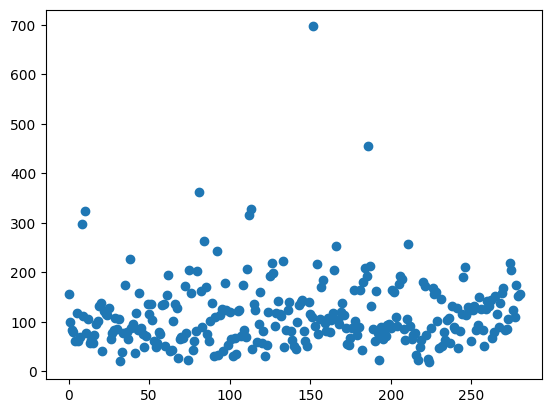

In [40]:
x = list(range(len(token_length_data)))
plt.scatter(x, pos_lens, label="Positive")

<BarContainer object of 281 artists>

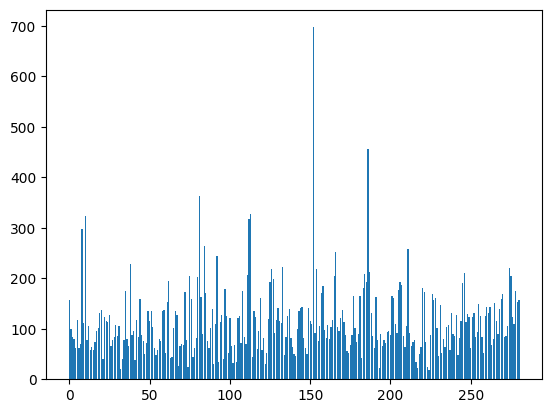

In [31]:
plt.bar(x, pos_lens, label=[e["thm_idx"] for e in data])

<BarContainer object of 281 artists>

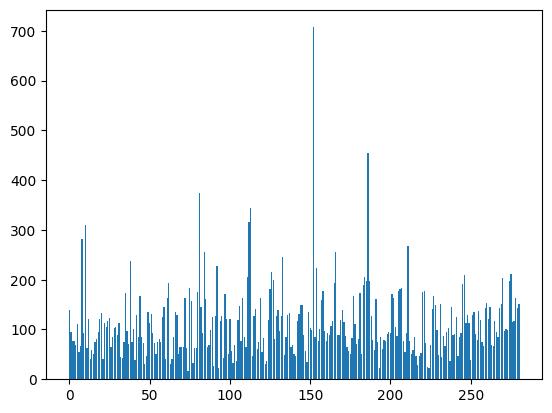

In [41]:
plt.bar(x, height=neg_lens, label=[e["thm_idx"] for e in data])

In [39]:
x

156

In [37]:
neg_lens

[140,
 95,
 76,
 77,
 69,
 111,
 55,
 67,
 281,
 93,
 310,
 63,
 121,
 40,
 59,
 51,
 74,
 81,
 95,
 121,
 133,
 41,
 113,
 105,
 118,
 123,
 65,
 84,
 103,
 104,
 88,
 113,
 44,
 42,
 74,
 174,
 96,
 71,
 237,
 75,
 101,
 39,
 129,
 85,
 167,
 85,
 73,
 30,
 47,
 135,
 113,
 131,
 92,
 72,
 51,
 74,
 80,
 74,
 126,
 146,
 40,
 164,
 194,
 31,
 41,
 85,
 136,
 130,
 50,
 65,
 65,
 64,
 163,
 62,
 16,
 184,
 157,
 33,
 62,
 63,
 176,
 374,
 145,
 92,
 255,
 162,
 65,
 69,
 98,
 126,
 26,
 128,
 227,
 23,
 118,
 127,
 42,
 171,
 121,
 51,
 121,
 57,
 33,
 69,
 37,
 120,
 147,
 76,
 164,
 85,
 65,
 206,
 315,
 345,
 46,
 127,
 141,
 61,
 74,
 163,
 54,
 82,
 30,
 37,
 119,
 181,
 215,
 200,
 81,
 127,
 139,
 97,
 128,
 246,
 49,
 85,
 129,
 133,
 64,
 69,
 50,
 46,
 117,
 132,
 149,
 149,
 89,
 57,
 34,
 135,
 102,
 98,
 707,
 85,
 223,
 77,
 100,
 159,
 178,
 97,
 77,
 93,
 89,
 108,
 117,
 193,
 256,
 89,
 88,
 119,
 140,
 116,
 87,
 64,
 56,
 51,
 82,
 167,
 111,
 71,
 80,
 174,
 50,
 

In [34]:
for i, x in enumerate(pos_lens):
    if x > 600:
        print(i, x)

152 697


In [42]:
d = data[152]

In [44]:
enc = tok.encode(d["state_before"])

In [45]:
len(enc)

693

In [46]:
print(d["state_before"])

C₁ : Type u_1
C₂ : Type u_2
D : Type u_3
I₁ : Type u_4
I₂ : Type u_5
J : Type u_6
inst✝¹¹ : Category.{u_9, u_1} C₁
inst✝¹⁰ : Category.{u_8, u_2} C₂
inst✝⁹ : Category.{u_7, u_3} D
inst✝⁸ : Preadditive C₁
inst✝⁷ : Preadditive C₂
inst✝⁶ : Preadditive D
c₁ : ComplexShape I₁
c₂ : ComplexShape I₂
K₁ L₁ : HomologicalComplex C₁ c₁
f₁ f₁' : K₁ ⟶ L₁
h₁ : Homotopy f₁ f₁'
K₂ L₂ : HomologicalComplex C₂ c₂
f₂ : K₂ ⟶ L₂
F : C₁ ⥤ C₂ ⥤ D
inst✝⁵ : F.Additive
inst✝⁴ : ∀ (X₁ : C₁), (F.obj X₁).Additive
c : ComplexShape J
inst✝³ : DecidableEq J
inst✝² : TotalComplexShape c₁ c₂ c
inst✝¹ : K₁.HasMapBifunctor K₂ F c
inst✝ : L₁.HasMapBifunctor L₂ F c
i₁ i₁' : I₁
i₂ : I₂
j j' : J
h : c₁.π c₂ c (i₁', i₂) = j
h' : c₁.prev i₁' = i₁
⊢ K₁.ιMapBifunctor K₂ F c i₁' i₂ j h ≫ hom₁ h₁ f₂ F c j j' =
    c₁.ε₁ c₂ c (i₁, i₂) •
      (F.map (h₁.hom i₁' i₁)).app (K₂.X i₂) ≫ (F.obj (L₁.X i₁)).map (f₂.f i₂) ≫ L₁.ιMapBifunctorOrZero L₂ F c i₁ i₂ j'


In [23]:
len(pos_lens)

208

In [2]:
src_data_path = "../data/time_filtered_val.json"
with open(src_data_path) as f:
    src_data = json.load(f)

In [3]:
len(src_data)

214

In [4]:
keys = list(src_data.keys())
src_data_sample = {k: src_data[k] for k in keys[:5]}

In [5]:
src_data_sample[keys[0]]

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': 'Mathlib/Algebra/MvPolynomial/Degrees.lean',
 'full_name': 'MvPolynomial.degrees_map_of_injective',
 'start': [214, 1],
 'end': [216, 66],
 'traced_tactics': [{'tactic': 'simp only [degrees, MvPolynomial.support_map_of_injective _ hf]',
   'annotated_tactic': ['simp only [<a>degrees</a>, <a>MvPolynomial.support_map_of_injective</a> _ hf]',
    [{'full_name': 'MvPolynomial.degrees',
      'def_path': 'Mathlib/Algebra/MvPolynomial/Degrees.lean',
      'def_pos': [79, 5],
      'def_end_pos': [79, 12]},
     {'full_name': 'MvPolynomial.support_map_of_injective',
      'def_path': 'Mathlib/Algebra/MvPolynomial/Basic.lean',
      'def_pos': [1450, 9],
      'def_end_pos': [1450, 33]}]],
   'state_before': 'R : Type u\nS : Type v\nσ : Type u_1\nτ : Type u_2\nr : R\ne : ℕ\nn m : σ\ns : σ →₀ ℕ\ninst✝¹ : CommSemiring R\np✝ q : MvPolynomial σ R\ninst✝ : CommSemiring S\

In [6]:
sampled_data_path = "../data/sample_proofs.json"
with open(sampled_data_path) as f:
    sampled_data = json.load(f)

In [7]:
print(
    type(sampled_data),
    len(sampled_data),
    len(sampled_data[0]),
)

<class 'list'> 5 32


In [8]:
pr00 = sampled_data[0][0]

In [10]:
print(pr00)

  /-
  We aim to show that the degrees of the polynomial obtained by mapping a multivariate polynomial \( p \) over \( R \) to a multivariate polynomial over \( S \) using an injective ring homomorphism \( f \) are the same as the degrees of the original polynomial \( p \).
  1. **Extensionality**: We use the fact that two multisets are equal if they have the same elements with the same multiplicities.
  2. **Monadicity**: The degrees of a polynomial are defined in terms of the union of multisets from the support of the polynomial.
  3. **Injective Function**: Since \( f \) is injective, the image of each coefficient under \( f \) is uniquely determined, ensuring that the degrees of the polynomial remain unchanged.
  -/
  -- Use the extensionality principle for multisets to show equality.
  rw [MvPolynomial.degrees_map]
  -- Since f is injective, the degrees of the polynomial remain unchanged.
  -- This is because the image of each coefficient under f is uniquely determined.
  <;> simp

# Fixing batch completion probability function

In [29]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [72]:
model_id = "deepseek-ai/DeepSeek-Prover-V1"
tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


In [73]:
if tok.pad_token_id is None:
    tok.pad_token_id = tok.eos_token_id

In [95]:
# original impl
def batch_completion_probabilities(
    model,
    tokenizer,
    prompt_completion_pairs,
    sep="",
    device=None,
):
    input_texts = []
    # idx of first completion char + last completion char
    start_char_idxs = []
    end_char_idxs = []
    for prompt, completion in prompt_completion_pairs:
        text = prompt + sep + completion
        input_texts.append(text)
        start_char_idxs.append(len(prompt) + len(sep))
        print(f"start: {start_char_idxs[-1]}")
        end_char_idxs.append(len(text) - 1)
    
    batch_enc = tokenizer(input_texts, padding=True, return_tensors="pt")
    input_ids = batch_enc.input_ids
    if device:
        input_ids = input_ids.to(device)
    outputs = model(input_ids)
    probs = torch.log_softmax(outputs.logits, dim=-1).detach()

    start_token_idxs = []
    for i, char_idx in enumerate(start_char_idxs):
        start_token_idxs.append(batch_enc.char_to_token(i, char_idx))
        print(i, char_idx, start_token_idxs[-1], batch_enc.input_ids[i])
    # start_token_idxs = [batch_enc.char_to_token(i, char_idx) for i, char_idx in enumerate(start_char_idxs)]
    end_token_idxs = [batch_enc.char_to_token(i, char_idx) for i, char_idx in enumerate(end_char_idxs)]

    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    probs = probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)

    batch = []
    for input_probs, start_idx, end_idx in zip(gen_probs, start_token_idxs, end_token_idxs):
        print(input_probs, start_idx, end_idx)
        completion_log_prob = input_probs[start_idx:end_idx+1].sum().item()
        batch.append({
            "log_prob_sum": completion_log_prob,
            "token_count": end_idx - start_idx + 1,
        })
    return batch

In [83]:
text = "The earth is round"

In [84]:
tok.encode(text)

[100000, 549, 6039, 317, 4078]

In [91]:
start_idx = len("The earth is ")
print(start_idx)

13


In [86]:
text[start_idx:]

'round'

In [87]:
benc = tok(text, return_tensors="pt")

In [92]:
benc.input_ids

tensor([[100000,    549,   6039,    317,   4078]])

In [88]:
benc.char_to_token(0, start_idx)

4

In [27]:
prompt_completion_pairs = [
    ("The earth is" , " flat."),
    ("The earth is" , " round."),
    ("The earth is" , " flat"),
    ("The earth is" , " round"),
    ("The earth is " , "flat"),
    ("The earth is " , "round"),
]

In [98]:
batch_completion_probabilities(model, tok, prompt_completion_pairs)

start: 12
start: 12
start: 12
start: 12
start: 13
start: 13
0 12 4 tensor([100000,    549,   6039,    317,   7372,     13])
1 12 4 tensor([100000,    549,   6039,    317,   4078,     13])
2 12 5 tensor([100001, 100000,    549,   6039,    317,   7372])
3 12 5 tensor([100001, 100000,    549,   6039,    317,   4078])
4 13 5 tensor([100001, 100000,    549,   6039,    317,   7372])
5 13 5 tensor([100001, 100000,    549,   6039,    317,   4078])
tensor([-13.3202, -10.2705,  -1.7378,  -6.4810,  -3.7067]) 4 5
tensor([-13.3202, -10.2705,  -1.7378,  -4.2532,  -2.2360]) 4 5
tensor([-31.7360,  -8.6571,  -9.9023,  -1.1810,  -6.5289]) 5 5
tensor([-31.7360,  -8.6571,  -9.9023,  -1.1810,  -4.6776]) 5 5
tensor([-31.7360,  -8.6571,  -9.9023,  -1.1810,  -6.5289]) 5 5
tensor([-31.7360,  -8.6571,  -9.9023,  -1.1810,  -4.6776]) 5 5


[{'log_prob_sum': -3.7066965103149414, 'token_count': 2},
 {'log_prob_sum': -2.2359964847564697, 'token_count': 2},
 {'log_prob_sum': 0.0, 'token_count': 1},
 {'log_prob_sum': 0.0, 'token_count': 1},
 {'log_prob_sum': 0.0, 'token_count': 1},
 {'log_prob_sum': 0.0, 'token_count': 1}]

## fixing the padding problem

Notice how in the tensors, the 549 token has different log prob depending on whether it is BOS -> 549 vs. EOS (temp pad) -> BOS -> 549
- this clearly demonstrates that we're not actually ignoring the pad token

probably just need to pass the attention mask from tokenization

but I also want to add the pad token as an actual token instead of just using EOS token so we might be able to attend to the EOS token

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

/opt/conda/envs/gfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
dsp_v1_model_id = "deepseek-ai/DeepSeek-Prover-V1"
tok = AutoTokenizer.from_pretrained(dsp_v1_model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(dsp_v1_model_id, trust_remote_code=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


In [19]:
print(f"model vocab size: {model.config.vocab_size}")
print(f"tokenizer vocab size: {len(tok)}")

model vocab size: 102400
tokenizer vocab size: 100002


In [20]:
print(tok.pad_token is None)
print(tok.pad_token_id is None)

True
True


In [21]:
# enabling import from `proof_flow` package
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import importlib
# import module
# importlib.reload(module)
# from module import function

In [23]:
import proof_flow.src.utils
importlib.reload(proof_flow.src.utils)
from proof_flow.src.utils import set_up_padding

In [24]:
set_up_padding(
    model,
    tok,
    token_embedding_multiple=64,
)

Tokenizer pad token ID: 100002
Model pad token ID: 100002


In [25]:
model.config.vocab_size

102400

In [26]:
def bcp_fixed_attn(
    model,
    tokenizer,
    prompt_completion_pairs,
    sep="",
    device=None,
):
    input_texts = []
    # idx of first completion char + last completion char
    start_char_idxs = []
    end_char_idxs = []
    for prompt, completion in prompt_completion_pairs:
        text = prompt + sep + completion
        input_texts.append(text)
        start_char_idxs.append(len(prompt) + len(sep))
        print(f"start: {start_char_idxs[-1]}")
        end_char_idxs.append(len(text) - 1)
    
    batch_enc = tokenizer(input_texts, padding=True, return_tensors="pt")
    if device:
        # input_ids = input_ids.to(device)
        batch_enc = batch_enc.to(device)
    input_ids = batch_enc.input_ids
    outputs = model(**batch_enc)
    probs = torch.log_softmax(outputs.logits, dim=-1).detach()

    start_token_idxs = []
    for i, char_idx in enumerate(start_char_idxs):
        start_token_idxs.append(batch_enc.char_to_token(i, char_idx))
        print(i, char_idx, start_token_idxs[-1], batch_enc.input_ids[i])
    # start_token_idxs = [batch_enc.char_to_token(i, char_idx) for i, char_idx in enumerate(start_char_idxs)]
    end_token_idxs = [batch_enc.char_to_token(i, char_idx) for i, char_idx in enumerate(end_char_idxs)]

    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    probs = probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)

    batch = []
    for input_probs, start_idx, end_idx in zip(gen_probs, start_token_idxs, end_token_idxs):
        print(input_probs, start_idx, end_idx)
        completion_log_prob = input_probs[start_idx:end_idx+1].sum().item()
        batch.append({
            "log_prob_sum": completion_log_prob,
            "token_count": end_idx - start_idx + 1,
        })
    return batch

In [30]:
bcp_fixed_attn(model, tok, prompt_completion_pairs)

start: 12
start: 12
start: 12
start: 12
start: 13
start: 13
0 12 4 tensor([100000,    549,   6039,    317,   7372,     13])
1 12 4 tensor([100000,    549,   6039,    317,   4078,     13])
2 12 5 tensor([100002, 100000,    549,   6039,    317,   7372])
3 12 5 tensor([100002, 100000,    549,   6039,    317,   4078])
4 13 5 tensor([100002, 100000,    549,   6039,    317,   7372])
5 13 5 tensor([100002, 100000,    549,   6039,    317,   4078])
tensor([-13.3202, -10.2705,  -1.7378,  -6.4810,  -3.7067]) 4 5
tensor([-13.3202, -10.2705,  -1.7378,  -4.2532,  -2.2360]) 4 5
tensor([-12.7493, -13.3202, -10.2705,  -1.7378,  -6.4810]) 5 5
tensor([-14.5206, -13.3202, -10.2705,  -1.7378,  -4.2532]) 5 5
tensor([-12.7493, -13.3202, -10.2705,  -1.7378,  -6.4810]) 5 5
tensor([-14.5206, -13.3202, -10.2705,  -1.7378,  -4.2532]) 5 5


[{'log_prob_sum': -3.7066965103149414, 'token_count': 2},
 {'log_prob_sum': -2.2359964847564697, 'token_count': 2},
 {'log_prob_sum': 0.0, 'token_count': 1},
 {'log_prob_sum': 0.0, 'token_count': 1},
 {'log_prob_sum': 0.0, 'token_count': 1},
 {'log_prob_sum': 0.0, 'token_count': 1}]

ok nice, the attention mask is passed and the padding works as expected.
The next step is to figure out the index components that's making the the single token completion break

In [33]:
def bcp_fixed_1tc(
    model,
    tokenizer,
    prompt_completion_pairs,
    sep="",
    device=None,
):
    input_texts = []
    # idx of first completion char + last completion char
    start_char_idxs = []
    end_char_idxs = []
    for prompt, completion in prompt_completion_pairs:
        text = prompt + sep + completion
        input_texts.append(text)
        start_char_idxs.append(len(prompt) + len(sep))
        print(f"start: {start_char_idxs[-1]}")
        end_char_idxs.append(len(text) - 1)
    
    batch_enc = tokenizer(input_texts, padding=True, return_tensors="pt")
    # 1tc version has only 4 tokens (+ bos), so we add a pad to the front
    # - now the last token "yes" is at index 5
    # - this is correctly picked up by char_to_token
    if device:
        # input_ids = input_ids.to(device)
        batch_enc = batch_enc.to(device)
    input_ids = batch_enc.input_ids
    outputs = model(**batch_enc)
    print("out logits shape:", outputs.logits.shape)
    """
    assumed output logit shape
    (batch_size, seq_len, vocab_size)
    """
    probs = torch.log_softmax(outputs.logits, dim=-1).detach()

    start_token_idxs = []
    for i, char_idx in enumerate(start_char_idxs):
        start_token_idxs.append(batch_enc.char_to_token(i, char_idx) - 1)
        print(i, char_idx, start_token_idxs[-1], batch_enc.input_ids[i])
    # start_token_idxs = [batch_enc.char_to_token(i, char_idx) for i, char_idx in enumerate(start_char_idxs)]
    end_token_idxs = [batch_enc.char_to_token(i, char_idx) for i, char_idx in enumerate(end_char_idxs)]

    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    # probs shape: (batch_size, seq_len - 1, vocab_size)
    # - probs[batch_i, j] corresponds to probability distribution of tokens AFTER token j
    # we don't care about the probability AFTER the last token
    probs = probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    # by skipping the first token in input ids, we move it forward, so now input_ids[j] is token j and probs[j] is the distribution
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)
    print("gp shape", gen_probs.shape)

    batch = []
    for input_probs, start_idx, end_idx in zip(gen_probs, start_token_idxs, end_token_idxs):
        print(input_probs, start_idx, end_idx)
        completion_log_prob = input_probs[start_idx:end_idx].sum().item()
        batch.append({
            "log_prob_sum": completion_log_prob,
            "token_count": end_idx - start_idx,
        })
    return batch

In [34]:
bcp_fixed_1tc(model, tok, prompt_completion_pairs)

start: 12
start: 12
start: 12
start: 12
start: 13
start: 13
out logits shape: torch.Size([6, 6, 102400])
0 12 3 tensor([100000,    549,   6039,    317,   7372,     13])
1 12 3 tensor([100000,    549,   6039,    317,   4078,     13])
2 12 4 tensor([100002, 100000,    549,   6039,    317,   7372])
3 12 4 tensor([100002, 100000,    549,   6039,    317,   4078])
4 13 4 tensor([100002, 100000,    549,   6039,    317,   7372])
5 13 4 tensor([100002, 100000,    549,   6039,    317,   4078])
gp shape torch.Size([6, 5])
tensor([-13.3202, -10.2705,  -1.7378,  -6.4810,  -3.7067]) 3 5
tensor([-13.3202, -10.2705,  -1.7378,  -4.2532,  -2.2360]) 3 5
tensor([-12.7493, -13.3202, -10.2705,  -1.7378,  -6.4810]) 4 5
tensor([-14.5206, -13.3202, -10.2705,  -1.7378,  -4.2532]) 4 5
tensor([-12.7493, -13.3202, -10.2705,  -1.7378,  -6.4810]) 4 5
tensor([-14.5206, -13.3202, -10.2705,  -1.7378,  -4.2532]) 4 5


[{'log_prob_sum': -10.18773078918457, 'token_count': 2},
 {'log_prob_sum': -6.489192008972168, 'token_count': 2},
 {'log_prob_sum': -6.481030464172363, 'token_count': 1},
 {'log_prob_sum': -4.253195762634277, 'token_count': 1},
 {'log_prob_sum': -6.481030464172363, 'token_count': 1},
 {'log_prob_sum': -4.253195762634277, 'token_count': 1}]

In [37]:
def bcp_v2(
    model,
    tokenizer,
    prompt_completion_pairs,
    sep="",
    device=None,
):
    input_texts = []
    start_char_idxs = [] # index of the first completion token
    end_char_idxs = []   # index of the last completion token
    for prompt, completion in prompt_completion_pairs:
        text = prompt + sep + completion
        input_texts.append(text)
        start_char_idxs.append(len(prompt) + len(sep))
        end_char_idxs.append(len(text) - 1)
    
    batch_enc = tokenizer(input_texts, padding=True, return_tensors="pt")
    if device:
        batch_enc = batch_enc.to(device)
    input_ids = batch_enc.input_ids
    outputs = model(**batch_enc) # ensure attention mask is passed
    log_prob_distributions = torch.log_softmax(outputs.logits, dim=-1).detach()

    # collect the probability of the generated token
    # - softmax(logits[b, i, :]) is the probability distribution for the token AFTER input_ids[b, i]
    # - (consequence 1): we don't care about the distribution after the last token in the input_ids
    log_prob_distributions = log_prob_distributions[:, :-1, :]
    # - while we have the distribution over the vocab after every token i,
    #   we only actually care about the probability of the actual next token
    # - i.e., we want softmax(logits[b, i, :])[input_ids[b, i+1]]
    # - notice the idx used for input_ids is i+1 while the idx used for log_probs is i
    # - for the gather operation, we need them aligned
    # - (consequence 2): we shift the input_ids forwards/leftwards by 1
    input_ids = input_ids[:, 1:]
    # - while logits has shape (batch_size, seq_len, vocab_size),
    #   and prob_distributions has shape (batch_size, seq_len - 1, vocab_size),
    #   the gather result has shape (batch_size, seq_len - 1)
    # - it's a batch of log probabilities of the actual sequence's tokens
    seq_log_probs = torch.gather(log_prob_distributions, 2, input_ids[:, :, None]).squeeze(-1)

    completion_log_probs = []
    for i in range(len(input_texts)):
        # start: token index of the first completion token
        # - the -1 is because the input_ids were shifted forward by 1
        # stop: token index of the token after the last completion token
        # - we use it as the end slice index, so we don't need to do -1
        start = batch_enc.char_to_token(i, start_char_idxs[i]) - 1
        stop = batch_enc.char_to_token(i, end_char_idxs[i])
        completion_log_prob = seq_log_probs[i, start:stop].sum().item()
        completion_log_probs.append({
            "log_prob_sum": completion_log_prob,
            "token_count": stop - start,
        })
    return completion_log_probs

In [38]:
bcp_v2(model, tok, prompt_completion_pairs)

[{'log_prob_sum': -10.18773078918457, 'token_count': 2},
 {'log_prob_sum': -6.489192008972168, 'token_count': 2},
 {'log_prob_sum': -6.481030464172363, 'token_count': 1},
 {'log_prob_sum': -4.253195762634277, 'token_count': 1},
 {'log_prob_sum': -6.481030464172363, 'token_count': 1},
 {'log_prob_sum': -4.253195762634277, 'token_count': 1}]

# remove failed negative tactics from rm eval data

In [4]:
with open("../data/rm_eval_dataset_v2.json") as f:
    rm_eval_data = json.load(f)

In [5]:
rm_eval_data[0]

{'thm_idx': '2',
 'state_before': 'R : Type u\nS : Type v\nσ : Type u_1\nτ : Type u_2\nr : R\ne : ℕ\nn m : σ\ns : σ →₀ ℕ\ninst✝¹ : CommSemiring R\np✝ q : MvPolynomial σ R\ninst✝ : CommSemiring S\np : MvPolynomial σ R\nf : R →+* S\nhf : Injective ⇑f\n⊢ ((map f) p).degrees = p.degrees',
 'positive': [{'tactic': 'simp only [degrees, MvPolynomial.support_map_of_injective _ hf]',
   'annotated_tactic': ['simp only [<a>degrees</a>, <a>MvPolynomial.support_map_of_injective</a> _ hf]',
    [{'full_name': 'MvPolynomial.degrees',
      'def_path': 'Mathlib/Algebra/MvPolynomial/Degrees.lean',
      'def_pos': [79, 5],
      'def_end_pos': [79, 12]},
     {'full_name': 'MvPolynomial.support_map_of_injective',
      'def_path': 'Mathlib/Algebra/MvPolynomial/Basic.lean',
      'def_pos': [1450, 9],
      'def_end_pos': [1450, 33]}]],
   'state_before': 'R : Type u\nS : Type v\nσ : Type u_1\nτ : Type u_2\nr : R\ne : ℕ\nn m : σ\ns : σ →₀ ℕ\ninst✝¹ : CommSemiring R\np✝ q : MvPolynomial σ R\ninst✝ : Com

In [5]:
wiped_count = 0
keep_count = 0
for entry in rm_eval_data:
    non_none_negs = []
    for i, tactic in enumerate(entry["negative"]):
        if tactic["state_after"] is not None:
            non_none_negs.append(i)
    if len(non_none_negs) > 0:
        keep_count += 1
    else:
        wiped_count += 1
    entry["negative_with_resulting_state"] = non_none_negs

In [6]:
print(wiped_count, keep_count)

73 206


In [10]:
nwrs_len = Counter([len(entry["negative_with_resulting_state"]) for entry in rm_eval_data])

In [12]:
nwrs_len

Counter({0: 73,
         1: 33,
         2: 31,
         3: 21,
         9: 15,
         8: 13,
         16: 12,
         7: 12,
         6: 12,
         5: 11,
         4: 11,
         13: 9,
         11: 7,
         14: 6,
         15: 5,
         10: 5,
         12: 3})

In [14]:
filtered_rm_eval = []
for entry in rm_eval_data:
    if len(entry["negative_with_resulting_state"]) > 0:
        modified_negs = [entry["negative"][i] for i in entry["negative_with_resulting_state"]]
        entry["negative"] = modified_negs
        filtered_rm_eval.append(entry)

In [15]:
len(filtered_rm_eval)

206

In [16]:
with open("../data/rm_eval_dataset_v3.json", 'w') as f:
    json.dump(filtered_rm_eval, f, indent=4)

# inspect datasets for multiline tactics

In [6]:
raw_eval_thm_path = "../data/time_filtered_val.json"
with open(raw_eval_thm_path) as f:
    raw_eval_thms = json.load(f)

In [9]:
for thm_idx, thm_info in raw_eval_thms.items():
    for entry in thm_info["traced_tactics"]:
        tactic = entry["tactic"]
        if tactic.startswith("cases"):
            print(thm_idx, tactic)

28 cases o₁ <;> cases o₂ <;> decide
68 cases a <;> rfl
83 cases n <;> constructor <;> rintro ⟨⟩ <;> rfl
114 cases x <;> rfl
128 cases a <;> rfl
329 cases x <;> simp only [pmap, bind_eq_bind, none_bind, some_bind, pbind]


In [10]:
raw_eval_thms["28"]

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': '.lake/packages/batteries/Batteries/Classes/Order.lean',
 'full_name': 'Ordering.then_eq_lt',
 'start': [20, 1],
 'end': [21, 35],
 'traced_tactics': [{'tactic': 'cases o₁ <;> cases o₂ <;> decide',
   'annotated_tactic': ['cases o₁ <;> cases o₂ <;> decide', []],
   'state_before': 'o₁ o₂ : Ordering\n⊢ o₁.then o₂ = lt ↔ o₁ = lt ∨ o₁ = eq ∧ o₂ = lt',
   'state_after': 'no goals'}],
 'formal_statement': 'theorem then_eq_lt {o₁ o₂ : Ordering} : o₁.then o₂ = lt ↔ o₁ = lt ∨ o₁ = eq ∧ o₂ = lt := by\n',
 'is_tactic_proof': True,
 'entry_time': 0.5851221249904484,
 'entry_failed': False}

In [17]:
def proof_starting_with(raw_eval_thms, tactic_prefix):
    thm_idxs = []
    for thm_idx, thm_info in raw_eval_thms.items():
        for entry in thm_info["traced_tactics"]:
            tactic = entry["tactic"]
            if tactic.startswith(tactic_prefix):
                thm_idxs.append(thm_idx)
    return thm_idxs

In [18]:
tis = proof_starting_with(raw_eval_thms, "induction")

In [20]:
tis

['48', '48', '209', '226', '263', '275', '306', '416']

In [22]:
tts = raw_eval_thms["48"]["traced_tactics"]

In [23]:
len(tts)

3

In [24]:
for tt in tts:
    print(tt["tactic"])

induction θ₁ using Real.Angle.induction_on
induction θ₂ using Real.Angle.induction_on
exact _root_.expMapCircle_add _ _


In [28]:
match_tis = proof_starting_with(raw_eval_thms, "cases")

In [29]:
match_tis

['28', '68', '83', '114', '128', '329']

In [30]:
train_data_path = "../data/time_filtered_v2.json"

In [31]:
with open(train_data_path) as f:
    train_data = json.load(f)

In [32]:
cases_tis = proof_starting_with(train_data, "cases")

In [33]:
len(cases_tis)

580

In [34]:
cases_tis[:10]

['57', '259', '282', '324', '439', '477', '485', '492', '603', '649']

In [35]:
for key in cases_tis:
    thm = train_data[key]
    if len(thm["traced_tactics"]) > 1:
        print(key, thm["traced_tactics"])
        break

259 [{'tactic': 'funext i', 'annotated_tactic': ['funext i', []], 'state_before': "α : Type u_1\nι : Type u_2\nι' : Type u_3\nv : ι → α\nl : Line α ι'\nx : α\n⊢ (fun x i => ((vertical v l).idxFun i).getD x) x = Sum.elim v ((fun x i => (l.idxFun i).getD x) x)", 'state_after': "case h\nα : Type u_1\nι : Type u_2\nι' : Type u_3\nv : ι → α\nl : Line α ι'\nx : α\ni : ι ⊕ ι'\n⊢ (fun x i => ((vertical v l).idxFun i).getD x) x i = Sum.elim v ((fun x i => (l.idxFun i).getD x) x) i"}, {'tactic': 'cases i <;> rfl', 'annotated_tactic': ['cases i <;> rfl', []], 'state_before': "case h\nα : Type u_1\nι : Type u_2\nι' : Type u_3\nv : ι → α\nl : Line α ι'\nx : α\ni : ι ⊕ ι'\n⊢ (fun x i => ((vertical v l).idxFun i).getD x) x i = Sum.elim v ((fun x i => (l.idxFun i).getD x) x) i", 'state_after': 'no goals'}]


In [36]:
train_data["259"]

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': 'Mathlib/Combinatorics/HalesJewett.lean',
 'full_name': 'Combinatorics.Line.vertical_apply',
 'start': [190, 1],
 'end': [193, 18],
 'traced_tactics': [{'tactic': 'funext i',
   'annotated_tactic': ['funext i', []],
   'state_before': "α : Type u_1\nι : Type u_2\nι' : Type u_3\nv : ι → α\nl : Line α ι'\nx : α\n⊢ (fun x i => ((vertical v l).idxFun i).getD x) x = Sum.elim v ((fun x i => (l.idxFun i).getD x) x)",
   'state_after': "case h\nα : Type u_1\nι : Type u_2\nι' : Type u_3\nv : ι → α\nl : Line α ι'\nx : α\ni : ι ⊕ ι'\n⊢ (fun x i => ((vertical v l).idxFun i).getD x) x i = Sum.elim v ((fun x i => (l.idxFun i).getD x) x) i"},
  {'tactic': 'cases i <;> rfl',
   'annotated_tactic': ['cases i <;> rfl', []],
   'state_before': "case h\nα : Type u_1\nι : Type u_2\nι' : Type u_3\nv : ι → α\nl : Line α ι'\nx : α\ni : ι ⊕ ι'\n⊢ (fun x i => ((vertical v l).idxFun i)

In [37]:
match_tis = proof_starting_with(train_data, "match")

In [38]:
len(match_tis)

3

In [39]:
match_tis

['13711', '16483', '19601']

In [41]:
match_thm = train_data[match_tis[0]]

In [42]:
for tt in match_thm["traced_tactics"]:
    print(tt["tactic"])

match a, h with
| some _, _ => simp only [unbot_coe, coe_le_coe]
simp only [unbot_coe, coe_le_coe]


In [45]:
mt1 = train_data[match_tis[1]]
len(mt1["traced_tactics"])

2

In [46]:
mt2 = train_data[match_tis[2]]
len(mt2["traced_tactics"])

2

In [47]:
mt2

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': 'Mathlib/Data/List/EditDistance/Defs.lean',
 'full_name': 'suffixLevenshtein_cons₁_aux',
 'start': [221, 1],
 'end': [224, 45],
 'traced_tactics': [{'tactic': 'match x, y with\n| ⟨hx :: tx, _⟩, ⟨hy :: ty, _⟩ => simp_all',
   'annotated_tactic': ['match x, y with\n  | ⟨hx :: tx, _⟩, ⟨hy :: ty, _⟩ => simp_all',
    []],
   'state_before': 'α : Type u_1\nβ : Type u_2\nδ : Type u_3\ninst✝¹ : AddZeroClass δ\ninst✝ : Min δ\nC : Cost α β δ\nx y : { r // 0 < r.length }\nw₀ : x.val[0] = y.val[0]\nw : x.val.tail = y.val.tail\n⊢ x = y',
   'state_after': 'no goals'},
  {'tactic': 'simp_all',
   'annotated_tactic': ['simp_all', []],
   'state_before': 'α : Type u_1\nβ : Type u_2\nδ : Type u_3\ninst✝¹ : AddZeroClass δ\ninst✝ : Min δ\nC : Cost α β δ\nx y : { r // 0 < r.length }\nhx : δ\ntx : List δ\nproperty✝¹ : 0 < (hx :: tx).length\nhy : δ\nty : List δ\nproperty✝ : 0 < (

In [49]:
induction_tis = proof_starting_with(train_data, "induction")
induction_tis

['29',
 '72',
 '102',
 '201',
 '308',
 '419',
 '451',
 '592',
 '868',
 '1162',
 '1215',
 '1456',
 '1884',
 '2162',
 '2284',
 '2314',
 '2346',
 '2428',
 '2480',
 '2518',
 '2751',
 '2768',
 '2818',
 '3193',
 '3253',
 '3376',
 '3484',
 '3869',
 '3906',
 '4245',
 '4295',
 '4536',
 '4604',
 '4678',
 '4704',
 '4705',
 '4752',
 '4764',
 '4773',
 '4831',
 '5157',
 '5213',
 '5351',
 '5534',
 '5903',
 '6001',
 '6495',
 '6752',
 '6801',
 '6801',
 '6965',
 '7044',
 '7308',
 '7393',
 '7413',
 '7445',
 '7545',
 '7699',
 '7747',
 '7839',
 '7961',
 '8050',
 '8150',
 '8169',
 '8249',
 '8316',
 '8400',
 '8432',
 '8808',
 '9071',
 '9107',
 '9193',
 '9208',
 '9267',
 '9290',
 '9547',
 '9573',
 '9581',
 '9637',
 '9643',
 '9848',
 '9945',
 '10256',
 '10290',
 '10318',
 '10388',
 '10534',
 '10544',
 '10547',
 '10735',
 '10864',
 '10881',
 '11128',
 '11206',
 '11543',
 '11600',
 '11806',
 '11863',
 '11881',
 '11884',
 '11995',
 '12027',
 '12038',
 '12331',
 '12347',
 '12494',
 '12498',
 '12514',
 '12593',
 '1

In [50]:
train_data[induction_tis[0]]

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': '.lake/packages/batteries/Batteries/Data/RBMap/Lemmas.lean',
 'full_name': 'Batteries.RBNode.Stream.foldl_eq_foldl_toList',
 'start': [209, 1],
 'end': [210, 75],
 'traced_tactics': [{'tactic': 'induction t generalizing init <;> simp [*, RBNode.foldl_eq_foldl_toList]',
   'annotated_tactic': ['induction t generalizing init <;> simp [*, <a>RBNode.foldl_eq_foldl_toList</a>]',
    [{'full_name': 'Batteries.RBNode.foldl_eq_foldl_toList',
      'def_path': '.lake/packages/batteries/Batteries/Data/RBMap/Lemmas.lean',
      'def_pos': [163, 9],
      'def_end_pos': [163, 30]}]],
   'state_before': 'α : Type u_1\nα✝ : Type u_2\nf : α✝ → α → α✝\ninit : α✝\nt : RBNode.Stream α\n⊢ foldl f init t = List.foldl f init t.toList',
   'state_after': 'no goals'}],
 'entry_time': 3.5393659160472453,
 'entry_failed': False}

In [51]:
for key in induction_tis:
    thm = train_data[key]
    for tt in thm["traced_tactics"]:
        t = tt["tactic"]
        if "induction" in t and "<;>" not in t:
            print(key, t)
            break

102 induction' h' with b c _ hbc ih
201 induction e
308 induction' h with n _ ih
868 induction s using Quot.inductionOn
1162 induction' n with n ih
2162 induction l using Quotient.inductionOn
2346 induction' l with x l IH
2428 induction' p with p
2480 induction' n with n ih generalizing f p
2518 induction' s using Multiset.induction with t s ih generalizing n
2751 induction l₁ generalizing l₂ i
2768 induction h
2818 induction' n with n ih
3193 induction' L with _ _ ih
3253 induction' L with t L IH
3484 induction' t with _ _ _ _ ih
3869 induction' g with Y' Z' g e ih
3906 induction' h with l' _ y l' _ hm
4245 induction' h with n _ IH
4295 induction' h with n _ IH
4678 induction' i with _ _ _ i_ih
4705 induction s using Quotient.inductionOn
4752 induction f using RatFunc.induction_on
5213 induction s using Quotient.inductionOn
5351 induction' K with a J IH generalizing f
6801 induction x using QuotientAddGroup.induction_on'
6801 induction x using QuotientAddGroup.induction_on'
6965 induc

In [53]:
train_data['28273']

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': 'Mathlib/Data/Multiset/Bind.lean',
 'full_name': 'Multiset.prod_join',
 'start': [89, 1],
 'end': [93, 29],
 'traced_tactics': [{'tactic': 'induction S using Multiset.induction with\n| empty => simp\n| cons _ _ ih => simp [ih]',
   'annotated_tactic': ['induction S using <a>Multiset.induction</a> with\n  | empty => simp\n  | cons _ _ ih => simp [ih]',
    [{'full_name': 'Multiset.induction',
      'def_path': 'Mathlib/Data/Multiset/Basic.lean',
      'def_pos': [168, 19],
      'def_end_pos': [168, 28]}]],
   'state_before': 'α : Type u_1\nβ : Type v\nγ : Type u_2\nδ : Type u_3\ninst✝ : CommMonoid α\nS : Multiset (Multiset α)\n⊢ S.join.prod = (map prod S).prod',
   'state_after': 'no goals'},
  {'tactic': 'simp',
   'annotated_tactic': ['simp', []],
   'state_before': 'case empty\nα : Type u_1\nβ : Type v\nγ : Type u_2\nδ : Type u_3\ninst✝ : CommMonoid α\n⊢ (

In [55]:
thm = train_data['28273']

In [54]:
from lean_dojo import Dojo, LeanGitRepo, Theorem

In [56]:
repo = LeanGitRepo(thm["url"], thm["commit"])

In [57]:
thm_obj = Theorem(repo, thm["file_path"], thm["full_name"])

In [58]:
tts = thm["traced_tactics"]
tactics = [tt["tactic"] for tt in tts]

In [59]:
for t in tactics:
    print(t, end='\n\n')

induction S using Multiset.induction with
| empty => simp
| cons _ _ ih => simp [ih]

simp

simp [ih]



In [74]:
t0 = tactics[0]
split_with = t0.split("with")
first = split_with[0].strip()
rest = "with" + split_with[1]
print(t0)

print(first)
print(rest)

induction S using Multiset.induction with
| empty => simp
| cons _ _ ih => simp [ih]
induction S using Multiset.induction
with
| empty => simp
| cons _ _ ih => simp [ih]


In [79]:
with Dojo(thm_obj) as (dojo, initial_state):
    state = initial_state
    res0 = dojo.run_tac(state, first)
    print(res0)
    res1 = dojo.run_tac(res0, "case empty => simp")
    print(res1)
    

TacticState(pp='case empty\nα : Type u_1\nβ : Type v\nγ : Type u_2\nδ : Type u_3\ninst✝ : CommMonoid α\n⊢ (join 0).prod = (map prod 0).prod\n\ncase cons\nα : Type u_1\nβ : Type v\nγ : Type u_2\nδ : Type u_3\ninst✝ : CommMonoid α\na✝¹ : Multiset α\ns✝ : Multiset (Multiset α)\na✝ : s✝.join.prod = (map prod s✝).prod\n⊢ (a✝¹ ::ₘ s✝).join.prod = (map prod (a✝¹ ::ₘ s✝)).prod', id=1, message='')
TacticState(pp='case cons\nα : Type u_1\nβ : Type v\nγ : Type u_2\nδ : Type u_3\ninst✝ : CommMonoid α\na✝¹ : Multiset α\ns✝ : Multiset (Multiset α)\na✝ : s✝.join.prod = (map prod s✝).prod\n⊢ (a✝¹ ::ₘ s✝).join.prod = (map prod (a✝¹ ::ₘ s✝)).prod', id=2, message='')


In [76]:
res1

LeanError(error='<stdin>:1:0: expected tactic')

In [80]:
from collections import Counter, defaultdict

In [82]:
findings = {
    "newline": [], 
    "newline_and_with": [], 
    "newline_no_with": [],
}
total_tactics = 0
for thm_idx, thm_info in train_data.items():
    for entry in thm_info["traced_tactics"]:
        total_tactics += 1
        tactic = entry["tactic"]
        if "\n" in tactic:
            findings["newline"].append(thm_idx)
            if "with" in tactic:
                findings["newline_and_with"].append(thm_idx)
            else:
                findings["newline_no_with"].append(thm_idx)

In [87]:
len(train_data)

12092

In [88]:
print(total_tactics)
for k, v in findings.items():
    print(k, len(v))

19366
newline 52
newline_and_with 17
newline_no_with 35


In [89]:
for thm_idx in findings["newline_no_with"]:
    thm_info = train_data[thm_idx]
    for entry in thm_info["traced_tactics"]:
        tactic = entry["tactic"]
        if "\n" in tactic:
            print(thm_idx, tactic)

1080 classical
rw [← toWithTop_lt, toWithTop_ofENat, toWithTop_ofENat]
1875 classical
  ext
  simp
2914 calc
  f x ≤ ⊥ := h h₁ h₂
  _ ≤ f ⊥ := bot_le
3626 exact filter_congr fun _ _ => by
  simpa using Nat.lt_succ_iff.symm
3988 classical
ext
simp [single_apply, Set.indicator, @eq_comm _ a]
4335 classical
funext x
simp [Function.extend_def, apply_dite₂]
4729 classical
  by_contra h
  exact w (isIso_of_mono_of_nonzero h)
4874 cases ax <;>
simp [Sentence.Realize, Formula.Realize, Fin.snoc]
5636 classical
simpa only [exists_prop, Finset.mem_image] using vars_rename f φ h
6290 classical
exact restrict_dite _ _
6313 classical
rw [← toWithTop_le, toWithTop_ofENat, toWithTop_ofENat]
6425 classical
ext s
rw [count_roots, rootMultiplicity_X_sub_C, count_singleton]
7736 cases p <;>
simp [smul_pow, smul_inv]
8027 classical
  ext
  simp
12799 classical
exact Decidable.List.Lex.ne_iff H
12986 induction x <;> induction y  <;>
  try { rfl }
13680 classical
  by_contra h
  exact w (isIso_of_epi_of_nonz

In [92]:
train_data['1080']

{'url': 'https://github.com/leanprover-community/mathlib4',
 'commit': '29dcec074de168ac2bf835a77ef68bbe069194c5',
 'file_path': 'Mathlib/Data/Nat/PartENat.lean',
 'full_name': 'PartENat.ofENat_lt',
 'start': [721, 1],
 'end': [723, 58],
 'traced_tactics': [{'tactic': 'classical\nrw [← toWithTop_lt, toWithTop_ofENat, toWithTop_ofENat]',
   'annotated_tactic': ['classical\n  rw [← <a>toWithTop_lt</a>, <a>toWithTop_ofENat</a>, <a>toWithTop_ofENat</a>]',
    [{'full_name': 'PartENat.toWithTop_lt',
      'def_path': 'Mathlib/Data/Nat/PartENat.lean',
      'def_pos': [668, 9],
      'def_end_pos': [668, 21]},
     {'full_name': 'PartENat.toWithTop_ofENat',
      'def_path': 'Mathlib/Data/Nat/PartENat.lean',
      'def_pos': [706, 9],
      'def_end_pos': [706, 25]},
     {'full_name': 'PartENat.toWithTop_ofENat',
      'def_path': 'Mathlib/Data/Nat/PartENat.lean',
      'def_pos': [706, 9],
      'def_end_pos': [706, 25]}]],
   'state_before': 'x y : ℕ∞\n⊢ ↑x < ↑y ↔ x < y',
   'state_after'